# Cat VS Dog

This notebook will tackle the traditional cat vs dog dataset https://www.kaggle.com/c/dogs-vs-cats

For simplicity, I am using only 500 images for training and 200 images for testing. It does give an indication though.

First, I will try to build a custom neural network. And then I will try some pretrained models (Transfer learning)



#Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L1L2, L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
from random import shuffle
import cv2

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# PreProcessing for ImageDataGenerator

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Organize data into train, valid, test dirs
DATA_PATH = '/content/gdrive/My Drive/Data for ImageDataGenerator/cats vs. dogs'
def organize_data(path=DATA_PATH):
for i in ['train', 'test']:
  os.chdir(f'{path}/{i}')

  if os.path.isdir('dog') is False:
      os.makedirs('dog')
      os.makedirs('cat')
      
      for c in tqdm(glob.glob('cat*')):
          shutil.move(c, 'cat')
      for c in tqdm(glob.glob('dog*')):
          shutil.move(c, 'dog')
  else:
      print('Already organized...')
    
os.chdir('../../')


organize_data()

TRAIN_PATH = f'{DATA_PATH}/train'
TEST_PATH = f'{DATA_PATH}/test'

Already organized...
Already organized...


# PreProcessing without ImageDataGenerator

In [ ]:
TRAIN_PATH = '/content/gdrive/My Drive/cats vs. dogs/train'
TEST_PATH = '/content/gdrive/My Drive/cats vs. dogs/test'
IMG_SIZE = 150

In [ ]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'cat': return [1, 0]
    else: return [0, 1]


def create_data(dir_path):
    training_data = []
    for img in tqdm(os.listdir(dir_path)):
        label = label_img(img)
        path = os.path.join(dir_path, img)
        img = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])

    shuffle(training_data)
    return training_data


In [ ]:
train = create_data(TRAIN_PATH)
test = create_data(TEST_PATH)

In [ ]:
train = np.array(train)
test = np.array(test)

print(train.shape)
print(test.shape)

(507, 2)
(210, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
X_train = np.array([img[0] for img in tqdm(train)]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_test = np.array([img[0] for img in tqdm(test)]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y_train = np.array([i[1] for i in tqdm(train)])
y_test = np.array([i[1] for i in tqdm(test)])

print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')


X_train shape (507, 150, 150, 3)
X_test shape (210, 150, 150, 3)
y_train shape (507, 2)
y_test shape (210, 2)


In [ ]:
X_train = X_train / 255
X_test = X_test / 255

#Models

## Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Some callbacks that we're using

MCP = ModelCheckpoint('Best_points_c.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights=True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

## Custom Models

In [ ]:
model1 = Sequential()

# Layer 1
model1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(150, 150, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))

# Layer 2
model1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

# Layer 3
model1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

# Layer 4
model1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Dropout(0.2))
# Flatten
model1.add(Flatten())

# Fully connected 1
model1.add(Dense(256, activation='tanh'))

# Output layer
model1.add(Dense(2, activation='softmax'))

# Compile
model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy', 'AUC'])

In [ ]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[RLP, MCP], )

Epoch 1/50
16/16 [==============================] - 1s 53ms/step - loss: 0.7349 - accuracy: 0.5352 - auc: 0.5276 - val_loss: 0.6915 - val_accuracy: 0.4762 - val_auc: 0.5590

Epoch 00001: val_accuracy did not improve from 0.75238
Epoch 2/50
16/16 [==============================] - 0s 30ms/step - loss: 0.6888 - accuracy: 0.5261 - auc: 0.5848 - val_loss: 0.6881 - val_accuracy: 0.6000 - val_auc: 0.6231

Epoch 00002: val_accuracy did not improve from 0.75238
Epoch 3/50
16/16 [==============================] - 0s 31ms/step - loss: 0.6898 - accuracy: 0.5573 - auc: 0.5490 - val_loss: 0.7010 - val_accuracy: 0.4810 - val_auc: 0.5360

Epoch 00003: val_accuracy did not improve from 0.75238
Epoch 4/50
16/16 [==============================] - 0s 31ms/step - loss: 0.6785 - accuracy: 0.6011 - auc: 0.6169 - val_loss: 0.6622 - val_accuracy: 0.6048 - val_auc: 0.6567

Epoch 00004: val_accuracy did not improve from 0.75238
Epoch 5/50
16/16 [==============================] - 0s 30ms/step - loss: 0.6539 - ac

### Keras-tuner

In [ ]:
pip install keras-tuner

In [ ]:
from tensorflow.keras.layers import MaxPooling2D

# Create a model using keras-tuner
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(filters=hp.Int('conv1_filter', min_value=32, max_value=64, step=16)
                     , kernel_size=hp.Choice('conv1_kernel', values=[3, 5])
                     , padding = 'same', activation='relu',\
                     input_shape=(28, 28, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(filters=hp.Int('conv2_filter', min_value=48, max_value=128, step=16), kernel_size=hp.Choice('conv2_kernel', values=[3, 5]) , padding = 'same', activation='selu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_unit', min_value=128, max_value=512, step=16), activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(units=2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])), metrics=['accuracy'])
    return model

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory='output1', project_name='CATDOG')
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

model = tuner.get_best_models(num_models=1)[0]
# model.summary()

INFO:tensorflow:Reloading Oracle from existing project output1/CATDOG/oracle.json
INFO:tensorflow:Reloading Tuner from output1/CATDOG/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models(num_models=1)[0]


In [ ]:
# Train the model

model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), initial_epoch=3, callbacks=[MCP,RLP])

Epoch 4/100
16/16 [==============================] - 1s 17ms/step - loss: 0.6568 - accuracy: 0.6123 - val_loss: 0.6811 - val_accuracy: 0.5619

Epoch 00004: val_accuracy did not improve from 0.71429
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.5644 - val_loss: 0.6926 - val_accuracy: 0.5095

Epoch 00005: val_accuracy did not improve from 0.71429
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6716 - accuracy: 0.5642 - val_loss: 0.6669 - val_accuracy: 0.6238

Epoch 00006: val_accuracy did not improve from 0.71429
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6377 - accuracy: 0.6300 - val_loss: 0.6589 - val_accuracy: 0.6333

Epoch 00007: val_accuracy did not improve from 0.71429
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6300 - accuracy: 0.6605 - val_loss: 0.6649 - val_accuracy: 0.5905

Epoch 00008: val_accuracy did not improve from 0.71429
Epoch 9/100
16

**First model was better**

## Pre-trained Models

### VGG16

In [ ]:
# Preprocessing data for vgg16

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=TRAIN_PATH, target_size=(224, 224), classes=['cat', 'dog'])

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=TEST_PATH, target_size=(224, 224), classes=['cat', 'dog'], shuffle=False)

Found 507 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


In [ ]:
# Download vgg16

from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16()

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Sence we are using the weights of ImageNet which has cats and dogs as classes in the original dataset, I freezed all the layers and just made some changes to the last layer.

model = Sequential()

for layer in vgg16.layers[:-1]:
  model.add(layer)

for layer in model.layers[:-1]:
  layer.trainable = False
  
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, epochs=10, validation_data=test_batches, callbacks=[MCP])

Epoch 1/10
16/16 [==============================] - 7s 414ms/step - loss: 10.2633 - accuracy: 0.8538 - val_loss: 7.6442 - val_accuracy: 0.9810

Epoch 00001: val_accuracy did not improve from 0.98571
Epoch 2/10
16/16 [==============================] - 6s 387ms/step - loss: 1.2913 - accuracy: 0.9917 - val_loss: 21.8605 - val_accuracy: 0.9571

Epoch 00002: val_accuracy did not improve from 0.98571
Epoch 3/10
16/16 [==============================] - 6s 385ms/step - loss: 6.0128 - accuracy: 0.9831 - val_loss: 19.6228 - val_accuracy: 0.9667

Epoch 00003: val_accuracy did not improve from 0.98571
Epoch 4/10
16/16 [==============================] - 6s 386ms/step - loss: 1.2267 - accuracy: 0.9949 - val_loss: 10.9182 - val_accuracy: 0.9857

Epoch 00004: val_accuracy did not improve from 0.98571
Epoch 5/10
16/16 [==============================] - 6s 389ms/step - loss: 0.4798 - accuracy: 0.9975 - val_loss: 23.0489 - val_accuracy: 0.9571

Epoch 00005: val_accuracy did not improve from 0.98571
Epoch

In [ ]:
vgg16_predictions = model.predict(x=test_batches)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
print(f'VGG16 Accuracy: {accuracy_score(test_batches.classes, np.argmax(vgg16_predictions, axis=-1))}')
print(f'VGG16 Confusion Matrix:\n {confusion_matrix(test_batches.classes, np.argmax(vgg16_predictions, axis=-1))}')
print(f'VGG16 Classification Report:\n {classification_report(test_batches.classes, np.argmax(vgg16_predictions, axis=-1))}')

VGG16 Accuracy: 0.9857142857142858
VGG16 Confusion Matrix:
 [[108   2]
 [  1  99]]
VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       110
           1       0.98      0.99      0.99       100

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



### DenseNet

In [ ]:
# Preprocessing data for vgg16

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
  .flow_from_directory(directory=TRAIN_PATH, target_size=(224, 224), classes=['cat', 'dog'])

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=TEST_PATH, target_size=(224, 224), classes=['cat', 'dog'], shuffle=False)

Found 507 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


In [ ]:
# This test batch won't be preprocessed so I can use it to analyze errors later

test_batches_orig = ImageDataGenerator() \
    .flow_from_directory(directory=TEST_PATH, target_size=(224, 224), classes=['cat', 'dog'], shuffle=False)

Found 210 images belonging to 2 classes.


In [ ]:
# Changed the patience and minimum learning rate here

RLP = ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.2,min_lr=0.00001)

In [ ]:
# Download DenseNet121

from tensorflow.keras.applications.densenet import DenseNet121
dns = DenseNet121(weights='imagenet')

33193984/33188688 [==============================] - 0s 0us/step


In [ ]:
dns.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# Added a couple of new layers to the end of the network.

from tensorflow.keras.models import Model
x = dns.layers[-1].output
x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
output = Dense(2, 'softmax')(x)

model = Model(inputs=dns.inputs, outputs=output)

for layer in model.layers[:-1]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=test_batches, epochs=30, callbacks=[MCP, RLP])

In [ ]:
from tensorflow.keras.models import load_model
bst = load_model('Best_points.h5')

In [ ]:
# Best accuracy was obtained by training DenseNet121 for about 100 epochs with the parameters above and without the RLP callback

bst.save('Dense_99.05_Acc.h5')

In [ ]:
predictions = bst.predict(test_batches)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

print(f'Dense121 Accuracy: {accuracy_score(test_batches.classes, np.argmax(predictions, axis=-1))}')
print(f'Dense121 Confusion Matrix:\n {confusion_matrix(test_batches.classes, np.argmax(predictions, axis=-1))}')
print(f'Dense121 Classification Report:\n {classification_report(test_batches.classes, np.argmax(predictions, axis=-1))}')


# Organized predictions and true values in a DataFrame to make it easier to analyze them.
temp_df = pd.DataFrame(np.array([test_batches.classes, np.argmax(predictions, axis=-1)]).T)
temp_df.columns = ['y_true', 'predictions']
cd = temp_df[(temp_df.y_true == 0) & (temp_df.predictions == 1)]
dc = temp_df[(temp_df.y_true == 1) & (temp_df.predictions == 0)]


# Organized test images in a numpy array instead of the sequence iterator
test_images_preprocessed = np.array([])
for i in range(7):
  imgs, labels = next(test_batches)
  for img in imgs:
    test_images_preprocessed = np.append(test_images_preprocessed, [[img]])
test_images_preprocessed=test_images_preprocessed.reshape(210, 224, 224, 3)


# Organized original test images (no preprocessing) in a numpy array instead of the sequence iterator
orig_test_images = np.array([])
for i in range(7):
  imgs, labels = next(test_batches_orig)
  for img in imgs:
    orig_test_images = np.append(orig_test_images, [[img]])
orig_test_images=orig_test_images.reshape(210, 224, 224, 3)


Dense121 Accuracy: 0.9904761904761905
Dense121 Confusion Matrix:
 [[109   1]
 [  1  99]]
Dense121 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       110
           1       0.99      0.99      0.99       100

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



**The model was wrong 2 times. one cat and one dog.** Let's take a look at them

In [ ]:
cd
# We have one cat the has been classified as a dog

,y_true,predictions
9,0,1


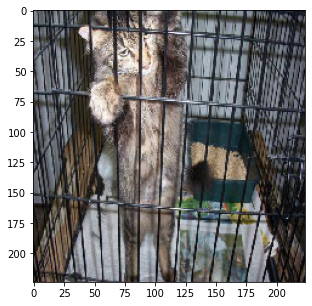

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(orig.astype('int')[9])

I made a quick review for the training set and found that whenever a cat image had this kind of fence in it, it will be behind the cat.

But with dogs, the cage tend to show up in front of them. I believe this is why the model wasn't able to recognize this as a cat.

It's worth telling that vgg16 was also wrong in this particular image

In [ ]:
dc
# We have one dog the has been classified as a cat

,y_true,predictions
151,1,0


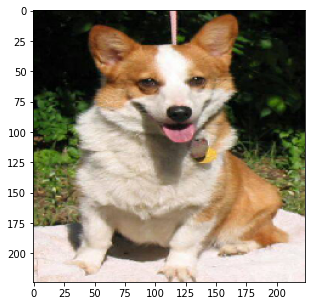

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(orig.astype('int')[151])

Well, for me, it does look like a cat!